# Use Neural Networks as a Classifier

In [22]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import pymongo
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics as mt

In [32]:
db = pymongo.MongoClient()['cousine']
recipes = db['foodcom']
label_field = 'category'
data = []
labels = ['italian', 'indian', 'mexican', 'chinese', 'greek', 'polish']

# Build the dataset with ingredients list + label for each recipe
q = {'search_terms': {'$in': labels}}
for recipe in recipes.find(q):
    data.append({
        'ingredients': recipe['ingredients'],
        label_field: [x for x in recipe['search_terms'] if x in labels][0]
    })

# Compute document frequency for each ingredient (+ cuisine frequency)
cuisine = defaultdict(list)
document_frequency = defaultdict(lambda: 0)
cuisine_frequency = defaultdict(lambda: defaultdict(lambda: 0))
for recipe in data:
    cuisine[recipe[label_field]].append(recipe)
    for ingredient in recipe['ingredients']:
        document_frequency[ingredient] += 1
        cuisine_frequency[recipe[label_field]][ingredient] += 1

In [12]:
# Split train and test data
train_data = data[:5000]
test_data = data[5000:6000]

In [13]:
# --------- Text-to-Vector Pipeline ---------

# Prepare a OHE to handle the labels
enc_labels = OneHotEncoder(handle_unknown='ignore')

# Build a vocabulary of the 1000 most frequent ingredients
vocabulary = list(pd.Series(document_frequency).sort_values(ascending=False).head(1000).keys().values)

# Filter the training data according to the vocabulary (keep only present ingredients)
def get_data(data, vocabulary):
    features, labels = [], []
    for recipe in data:
        features.append([f for f in recipe['ingredients'] if f in vocabulary])
        labels.append([recipe[label_field]])
    return features, labels
train_docs, train_labels = get_data(train_data, vocabulary)
test_docs, test_labels = get_data(test_data, vocabulary)

# Convert each ingredients list into a binary vector, of size equal to that of the vocabulary

X_train = np.zeros((len(train_docs), len(vocabulary)))
for i, doc in enumerate(train_docs):
    for ingredient in doc:
        X_train[i, vocabulary.index(ingredient)] = 1
y_train = enc_labels.fit_transform(np.array(train_labels)).toarray() # OHE the labels

X_test = np.zeros((len(test_docs), len(vocabulary)))
for i, doc in enumerate(test_docs):
    for ingredient in doc:
        X_test[i, vocabulary.index(ingredient)] = 1
y_test = enc_labels.transform(np.array(test_labels)).toarray()

In [14]:
class SimpleNet(nn.Module):

    def __init__(self, input_size, output_size):
        super(SimpleNet, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = F.softmax(self.fc(x), dim=0)
        return x

In [26]:
# Dataset
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=10)
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=10)

# Model
net = SimpleNet(X_train.shape[1], y_train.shape[1])

# Batches and labels
batches = [(doc, lab) for doc, lab in train_dataloader]
read_labels = [x.replace('x0_', '') for x in enc_labels.get_feature_names_out()]

# Loss
criterion = nn.BCEWithLogitsLoss()

# Training step
def train(document_tensor, label_tensor, criterion, learning_rate):
    net.zero_grad()
    output = net(document_tensor)
    loss = criterion(output, label_tensor)
    loss.backward()

    for p in net.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()


In [27]:
# Training

n_iters = 20000
learning_rate = 0.1
current_loss = 0
all_losses = list()

epochs = list(range(1, n_iters + 1))
for it in epochs:
    document_tensor, label_tensor = batches[np.random.randint(0, len(batches) - 1)]
    output, loss = train(document_tensor, label_tensor, criterion, learning_rate)
    current_loss += loss

    if it % 200 == 0:
        all_losses.append(current_loss / 200)
        current_loss = 0

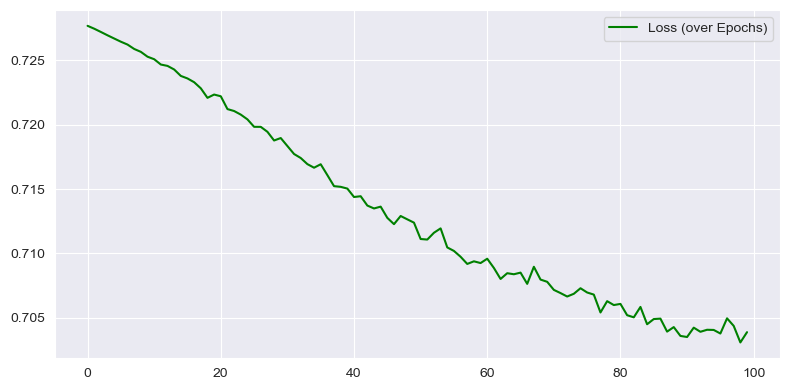

In [28]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(all_losses, 'g', label="Loss (over Epochs)")
plt.tight_layout()
plt.legend()
plt.show()

In [29]:
y_pred_train, y_true_train = [], []
for doc, lab in train_dataloader:
    output = net(doc)
    preds = torch.argmax(output, dim=1)
    ground = torch.argmax(lab, dim=1)
    for i, p in enumerate(preds):
        y_pred_train.append(p)
        g = ground[i]
        y_true_train.append(g)

y_pred, y_true = [], []
for doc, lab in test_dataloader:
    output = net(doc)
    preds = torch.argmax(output, dim=1)
    ground = torch.argmax(lab, dim=1)
    for i, p in enumerate(preds):
        y_pred.append(p)
        g = ground[i]
        y_true.append(g)

print(mt.classification_report(y_true_train, y_pred_train))
print(mt.classification_report(y_true, y_pred, zero_division=0))

Exception ignored in: <function tqdm.__del__ at 0x0000023B8D994180>
Traceback (most recent call last):
  File "C:\Users\Filippo Corti\miniconda3\envs\SocialMediaMining\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "C:\Users\Filippo Corti\miniconda3\envs\SocialMediaMining\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


              precision    recall  f1-score   support

           0       0.44      0.79      0.56       479
           1       0.34      0.59      0.43       452
           2       0.57      0.66      0.61       730
           3       0.87      0.48      0.61      1733
           4       0.85      0.54      0.66      1518
           5       0.08      0.56      0.14        88

    accuracy                           0.56      5000
   macro avg       0.52      0.60      0.50      5000
weighted avg       0.72      0.56      0.60      5000

              precision    recall  f1-score   support

           0       0.46      0.68      0.55       114
           1       0.35      0.57      0.43       100
           2       0.79      0.57      0.67       214
           3       0.80      0.51      0.62       313
           4       0.76      0.56      0.65       244
           5       0.06      0.53      0.11        15

    accuracy                           0.56      1000
   macro avg       0.54

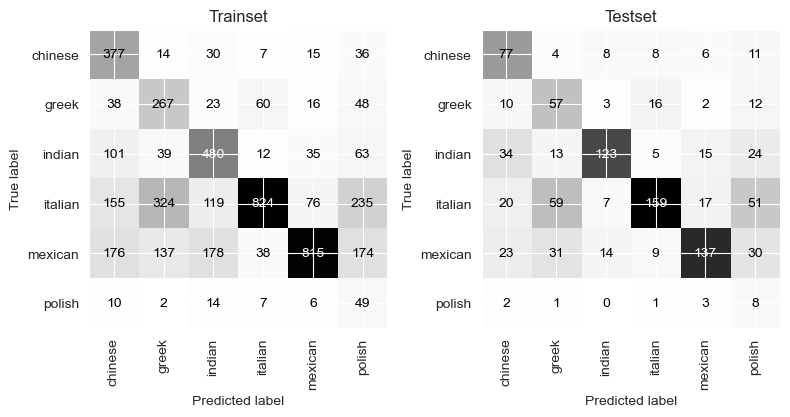

In [30]:
fig, ax = plt.subplots(figsize=(8, 6), ncols=2)
cmd_train = mt.ConfusionMatrixDisplay(confusion_matrix=mt.confusion_matrix(y_true_train, y_pred_train),
                                      display_labels=read_labels)
cmd_test = mt.ConfusionMatrixDisplay(confusion_matrix=mt.confusion_matrix(y_true, y_pred),
                                     display_labels=read_labels)
cmd_train.plot(ax=ax[0], cmap='Greys', colorbar=False, xticks_rotation='vertical')
cmd_test.plot(ax=ax[1], cmap='Greys', colorbar=False, xticks_rotation='vertical')
ax[0].set_title('Trainset')
ax[1].set_title('Testset')
plt.tight_layout()
plt.show()

In [33]:
# Another thing we can do is computing similarities btween ingredients, based on which cuisine they appear in

params = {name: param.detach().numpy() for name, param in net.named_parameters()}
feature_vectors = pd.DataFrame(params['fc.weight'].T, index=vocabulary, columns=labels)

sigma = cosine_similarity(feature_vectors, feature_vectors)
S = pd.DataFrame(sigma, index=vocabulary, columns=vocabulary)

k_sigma = cosine_similarity(feature_vectors.T, feature_vectors.T)
K = pd.DataFrame(k_sigma, index=labels, columns=labels)

In [36]:
query = 'cucumber'
print(f"Ingredients similar to {query}")
S.loc[query].sort_values(ascending=False).head(10)

Ingredients similar to cucumber


cucumber               1.000000
sherry wine vinegar    0.947458
orzo pasta             0.935035
dried dill             0.928498
feta cheese            0.922638
pita bread             0.918042
chicken thighs         0.893402
phyllo dough           0.882244
red capsicum           0.871243
greek yogurt           0.870414
Name: cucumber, dtype: float32

In [37]:
query = 'mexican'
print(f"Cuisines similar to {query}")
K.loc[query].sort_values(ascending=False)

Cuisines similar to mexican


mexican    1.000000
polish    -0.013089
italian   -0.015269
greek     -0.164036
indian    -0.181801
chinese   -0.402595
Name: mexican, dtype: float32